In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from setting import *
from prehandle.Dataset import MyDataset
from tqdm import tqdm


In [3]:
# from pathlib2 import Path
# data_path = r"C:\Users\sivan\Downloads\LogdiffTest\difference data\runtimeapi2"
# data_path = Path(data_path)
# dataset = MyDataset(data_path, padding_length=50,stride=1)
# import pickle
# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

In [4]:
import pickle
dataset = pickle.load(open('dataset.pkl', 'rb'))
dataset.vocab_size

15940

In [5]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_classes, num_layers, seq_length):
        super(TransformerEncoder, self).__init__()
        self.transformer_encoder = nn.TransformerEncoder(
            # input: (seq_len, batch_size, embedding_dim)
            nn.TransformerEncoderLayer(embedding_dim, nhead=8, dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        self.fc = nn.Linear(seq_length, hidden_dim)
        self.out = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, embedding_dim)
        x = x.permute(1, 0, 2)  # (seq_len, batch_size, embedding_dim)
        x = self.transformer_encoder(x)# x: (seq_len, batch_size, embedding_dim)
        x = x.permute(1, 0, 2)  # (batch_size, seq_len, embedding_dim)
        x = x.mean(dim=2) # (batch_size, seq_len)
        x = self.fc(x) # (batch_size, hidden_dim)
        x = nn.ReLU()(x)
        x = self.out(x) # (batch_size, num_classes)
        return x

In [6]:
def train(model, train_loader, optimizer, criterion,epochs,device):
    model.train()
    loss_list = []
    for epoch in range(epochs):
        print('Epoch: {}'.format(epoch + 1))
        with tqdm(total=len(train_loader)) as pbar:
            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                loss_list.append(loss.item())
                pbar.set_postfix({'loss': '{:.6f}'.format(loss.item())})
                pbar.update(1)
    return loss_list

In [83]:
# hyperparameters
embedding_dim = dataset.model_dim
seq_length = dataset.padding_length * 2
num_classes = dataset.vocab_size
hidden_dim = num_classes // 2
num_layers = 3
batch_size = 128
lr = 0.001
epochs = 1
loader = DataLoader(dataset.data, batch_size=batch_size, shuffle=True)

In [8]:
# initialize model
model = TransformerEncoder(embedding_dim, hidden_dim, num_classes, num_layers, seq_length)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
model.to(device)
# define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [9]:
loss_list = train(model, loader, optimizer, criterion, epochs, device)

Epoch: 1


100%|██████████| 863/863 [02:28<00:00,  5.80it/s, loss=0.359982]


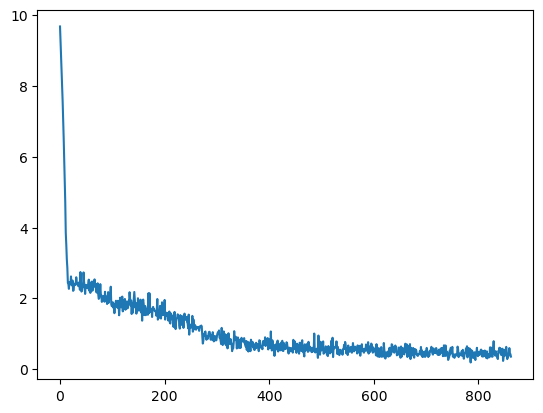

In [11]:
import matplotlib.pyplot as plt
plt.plot(loss_list)
plt.show()

In [89]:
def predict(model,data_loader,device,K=3):
    model.eval()
    predictions = []
    tar = []
    with torch.no_grad():
        for (data, target) in tqdm(data_loader):
            data = data.to(device)
            output = model(data)
            topk_values, topk_indices = torch.topk(output, k=K, dim=1)
            predictions.extend(topk_indices.tolist())
            tar.extend(target.tolist())
    return predictions, tar

def evaluate(y_true,y_pred):
    abnormal = []
    correct = 0
    for i in range(len(y_true)):
        if y_true[i] in y_pred[i]:
            correct += 1
        else:
            abnormal.append((i, y_true[i], y_pred[i]))
    accuracy = 100 * correct / len(y_true)
    return accuracy, abnormal

In [85]:
print("K=1")
predictions, y_true = predict(model,loader,device,K=1)
accuracy, abnormal = evaluate(y_true, predictions)
print("accuracy: {:.2f}%".format(accuracy))

print("K=2")
predictions, y_true = predict(model,loader,device,K=2)
accuracy, abnormal = evaluate(y_true, predictions)
print("accuracy: {:.2f}%".format(accuracy))

print("K=3")
predictions, y_true = predict(model,loader,device,K=3)
accuracy, abnormal = evaluate(y_true, predictions)
print("accuracy: {:.2f}%".format(accuracy))

K=1


100%|██████████| 863/863 [00:35<00:00, 24.12it/s]


accuracy: 85.67%
K=2


100%|██████████| 863/863 [00:35<00:00, 24.20it/s]


accuracy: 94.37%
K=3


100%|██████████| 863/863 [00:35<00:00, 24.17it/s]

accuracy: 96.52%


In [90]:
loader = DataLoader(dataset.data, batch_size=128, shuffle=False)
predictions, y_true = predict(model,loader,device,K=2)
accuracy, abnormal = evaluate(y_true, predictions)

100%|██████████| 863/863 [00:35<00:00, 23.99it/s]


In [95]:
# 将间断的不正常数据合并为连续的不正常区域
def get_consistent_abnormal(abnormal):
    consistent_abnormal = []
    left,right = abnormal[0][0], abnormal[0][0] + 1
    for i in range(1, len(abnormal)):
        if abnormal[i][0] == right:
            right += 1
        else:
            consistent_abnormal.append((left, right))
            left, right = abnormal[i][0], abnormal[i][0] + 1
    consistent_abnormal.append((left, right))
    return consistent_abnormal
consistent_abnormal = get_consistent_abnormal(abnormal)
consistent_abnormal


[(0, 76),
 (118, 119),
 (120, 125),
 (126, 127),
 (128, 129),
 (130, 131),
 (136, 137),
 (138, 144),
 (153, 220),
 (265, 270),
 (271, 306),
 (307, 369),
 (370, 408),
 (409, 411),
 (412, 415),
 (417, 418),
 (420, 423),
 (448, 456),
 (466, 467),
 (3857, 3858),
 (3886, 3888),
 (3889, 3890),
 (3891, 3896),
 (3939, 3947),
 (3949, 3951),
 (3954, 3955),
 (3960, 3961),
 (3962, 3965),
 (3971, 3972),
 (3975, 3976),
 (3985, 3986),
 (3989, 3990),
 (3994, 3995),
 (4002, 4003),
 (4008, 4009),
 (4013, 4014),
 (4023, 4024),
 (4033, 4036),
 (4040, 4041),
 (4053, 4054),
 (4059, 4060),
 (4063, 4065),
 (4068, 4069),
 (4076, 4077),
 (4080, 4084),
 (4091, 4092),
 (4102, 4103),
 (4110, 4111),
 (4120, 4121),
 (4130, 4131),
 (4139, 4141),
 (4143, 4144),
 (4153, 4154),
 (4166, 4167),
 (4171, 4172),
 (4183, 4184),
 (4193, 4194),
 (4203, 4204),
 (4208, 4209),
 (4211, 4212),
 (4214, 4215),
 (4216, 4217),
 (4225, 4226),
 (4232, 4235),
 (4240, 4241),
 (4246, 4247),
 (4253, 4254),
 (4260, 4261),
 (4262, 4264),
 (4267

In [97]:
from pathlib2 import Path
data_path = r"C:\Users\sivan\Downloads\LogdiffTest\difference data\runtimeapi1"
data_path = Path(data_path)
dataset = MyDataset(data_path, padding_length=50,stride=1)
loader = DataLoader(dataset.data, batch_size=128, shuffle=False)

100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


In [98]:
predictions, y_true = predict(model,loader,device,K=2)
accuracy, abnormal = evaluate(y_true, predictions)

100%|██████████| 912/912 [00:38<00:00, 23.86it/s]


In [99]:
accuracy

93.63305836148794

In [101]:
for i in range(len(abnormal)):
    if 157000<=abnormal[i][0]<=158000:
        print(abnormal[i])

In [106]:
abnormal[7000:]

[(114180, 14839, [14118, 9377]),
 (114182, 13307, [12221, 14118]),
 (114223, 14842, [14118, 14839]),
 (114226, 14842, [12221, 14839]),
 (114227, 14842, [14118, 14839]),
 (114640, 12235, [14118, 12221]),
 (114641, 11194, [12221, 14118]),
 (114642, 11194, [14118, 12221]),
 (114643, 11194, [14118, 12221]),
 (114645, 11194, [12221, 14118]),
 (114647, 12235, [14118, 12221]),
 (114649, 14829, [14118, 12221]),
 (114651, 12221, [14829, 14118]),
 (114653, 12235, [14118, 12221]),
 (114657, 11400, [13307, 12221]),
 (114663, 14842, [14118, 14829]),
 (114664, 13307, [12221, 11497]),
 (114666, 14839, [14118, 14829]),
 (114672, 11400, [11497, 13307]),
 (114673, 14842, [14118, 14839]),
 (114678, 14829, [14118, 14839]),
 (114683, 12221, [14118, 14119]),
 (114685, 11400, [11497, 13307]),
 (114686, 11194, [14118, 13307]),
 (114687, 12221, [14118, 14839]),
 (114688, 14842, [14118, 14839]),
 (114694, 11400, [13307, 11497]),
 (114695, 14842, [14118, 14839]),
 (114704, 14829, [14118, 14839]),
 (114706, 12221

In [107]:
len(abnormal)

7425